In [46]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import random

In [47]:
colors=['#19bdff','#f2d138'] #majority/minority
greycolor='#626262'
myblack='#222222'
repcolor='red'
demcolor='blue'
mygrey='#cfcfcf'
myred=  '#f2d138'#'#ea9999'
mygreen= '#19bdff' #'#93c47d'

TINY_SIZE = 9
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

dpival=100

mpl.rcParams['figure.dpi'] = dpival

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [48]:
# Load JSON data
with open('input/news_segments_2020-04_2021-04_unique_IDs.json') as file:
    data_list = json.load(file)

# Assuming each item in the list has a 'data' key, we extract those
extracted_data = [item['data'] for item in data_list]

# Normalize the data to flatten the nested structure
transcript_df = pd.json_normalize(extracted_data)

# The DataFrame `df` now contains the data with corresponding columns
print(transcript_df.columns)

Index(['text', 'meta_info.internal_id', 'meta_info.source', 'meta_info.date'], dtype='object')


In [49]:
Q3_response_counts=pd.read_csv("output/response_count_Q3.csv")

In [50]:

# Read the JSON file into a DataFrame
df = pd.read_json("input/recoded_transcripts/main-at-2024-05-28-recoded-mostly.json")
all_inner_IDs=pd.read_csv("input/recoded_transcripts/main_project_IDs.csv")


In [51]:
# take all the weeks
weeklyIDS=all_inner_IDs.iloc[0:2022]

In [52]:
annotator_list=df['annotator'].unique()
annotator_dict = {
    2: 'JE',
    3: 'EK',
    10: 'VR',
    4: 'CA',
    11: 'LU',
    13: 'PI',
    12: 'GE',
    14: 'TR',
    15: 'KA'
}


In [53]:
# select a subset of annotators if needed:
df = df[df['annotator'].isin(annotator_list)]
df['annotator'] = df['annotator'].map(annotator_dict)

In [54]:
# unpack the meta_info

expanded_columns = df['meta_info'].apply(pd.Series)
df = pd.concat([df.drop('meta_info', axis=1), expanded_columns], axis=1)

In [55]:
# drop unclears and does not mentions
df = df[df['climate_change'] != 'Unclear']
df = df[df['attitude'] != 'Unclear']
df = df[df['policy'] != 'Unclear']
# df = df[df['policy']!='Does not mention']

In [56]:
df['media_outlet'] = df['source'].str.split().str[0]

In [57]:
df['media_outlet'].unique()

array(['CNN', 'CBS', 'Fox', 'MSNBC', 'NBC', 'PBS', 'ABC'], dtype=object)

In [58]:
df = df.drop_duplicates(subset=['annotator', 'id'], keep='first') #drop a duplicate annotation 

In [59]:
#filter the df based on weekly annotations
df = df[df['internal_id'].isin(weeklyIDS["internal_id"])]

transcript_df = transcript_df[transcript_df['meta_info.internal_id'].isin(weeklyIDS["internal_id"])]

In [60]:
df= pd.merge(df, all_inner_IDs[['internal_id', 'project_id']], on='internal_id', how='left')

In [61]:
new_df = df[["text", "internal_id", "textbox"]]
# Convert all textbox values to strings
new_df['textbox'] = new_df['textbox'].astype(str)
# Group by project_id and concatenate the textbox values
merged_df = new_df.groupby('internal_id').agg({
    'text': 'first',  # Assuming we want to keep the first 'text' entry for each 'project_id'
    'textbox': ' '.join  # Concatenate 'textbox' values
}).reset_index()


/var/folders/v0/mrdbnbz979z112bjxxhzr3zh0000gn/T/ipykernel_36464/2187416615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['textbox'] = new_df['textbox'].astype(str)


In [62]:
# Function to convert each row to the desired JSON format
def row_to_json(row):
    return {
        "data": {
            "text": row['text'],
            "textbox": row['textbox'],
            "internal_id": row['internal_id']
        }
    }

# Apply the function to each row in the DataFrame and convert to a list of JSON objects
json_data = [row_to_json(row) for _, row in merged_df.iterrows()]

# Randomly permute the order of the JSON objects
random.shuffle(json_data)

# Convert list of JSON objects to JSON string
json_string = json.dumps(json_data, indent=4)

# Optionally, save to a file
with open('output/output.json', 'w') as f:
    f.write(json_string)

In [63]:
# Saving to a JSON file
with open('output/policy_mentions.json', 'w') as f:
    json.dump(json_string, f, indent=4)

print("Extraction complete!")

Extraction complete!


In [64]:
question_labels=['climate_change','attitude','policy']

In [65]:
## define dataframes for each question
Q1_df = df.pivot(index='annotator', columns=['project_id','media_outlet'], values=question_labels[0])
Q2_df = df.pivot(index='annotator', columns=['project_id','media_outlet'], values=question_labels[1])
Q3_df = df.pivot(index='annotator', columns=['project_id','media_outlet'], values=question_labels[2])


In [66]:
majority_rule_Q3_df_internal_id = Q3_df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

In [67]:
df_Q3_maj_rule = pd.DataFrame(majority_rule_Q3_df_internal_id)

In [68]:
df_Q3_maj_rule = df_Q3_maj_rule.reset_index()
df_Q3_maj_rule = df_Q3_maj_rule.rename(columns={0: 'response'})

In [69]:
## compute majority rule dataframes

majority_rule_Q1_df = Q1_df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
response_list_Q1=majority_rule_Q1_df.tolist()

majority_rule_Q2_df = Q2_df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
response_list_Q2=majority_rule_Q2_df.tolist()

majority_rule_Q3_df = Q3_df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
response_list_Q3=majority_rule_Q3_df.tolist()


In [70]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Does not mention"]
short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate'] 
short_Q3_choices=Q3_choices[:-2] #cut "does not mention"


In [71]:
def plot_responses_test(ax, response_list, choices, title, color_bars=True, labels=None,yoff=False):
    """
    Plot a bar chart of response counts on a given axis.

    Parameters:
    - ax: Axis to plot on.
    - response_list: List of responses to count.
    - choices: List of possible choices to ensure the correct order in the plot.
    - title: Title of the plot.
    - color_bars: Boolean indicating whether to color the bars differently.
    - labels: Optional custom labels for the bars.
    """
    # Count the occurrences of each response
    response_counts = Counter(response_list)
    # Reorder the response counts according to the order in choices
    ordered_counts = [response_counts[choice] for choice in choices]

    if labels is None:
        labels = choices

    # Determine bar colors
    bar_colors = [mygrey] * len(choices)
    if color_bars:
        bar_colors[0] = mygreen  # First bar color
        bar_colors[2] = myred  # Third bar color

    # Plotting with the order of choices
    ax.bar(labels, ordered_counts, color=bar_colors)

    sns.despine(ax=ax)

    # Set title and labels with specified font sizes
    ax.set_title(title)
    if yoff==True:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('Number of transcripts', fontsize=SMALL_SIZE)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, fontsize=SMALL_SIZE)  # Rotate labels to avoid overlapping


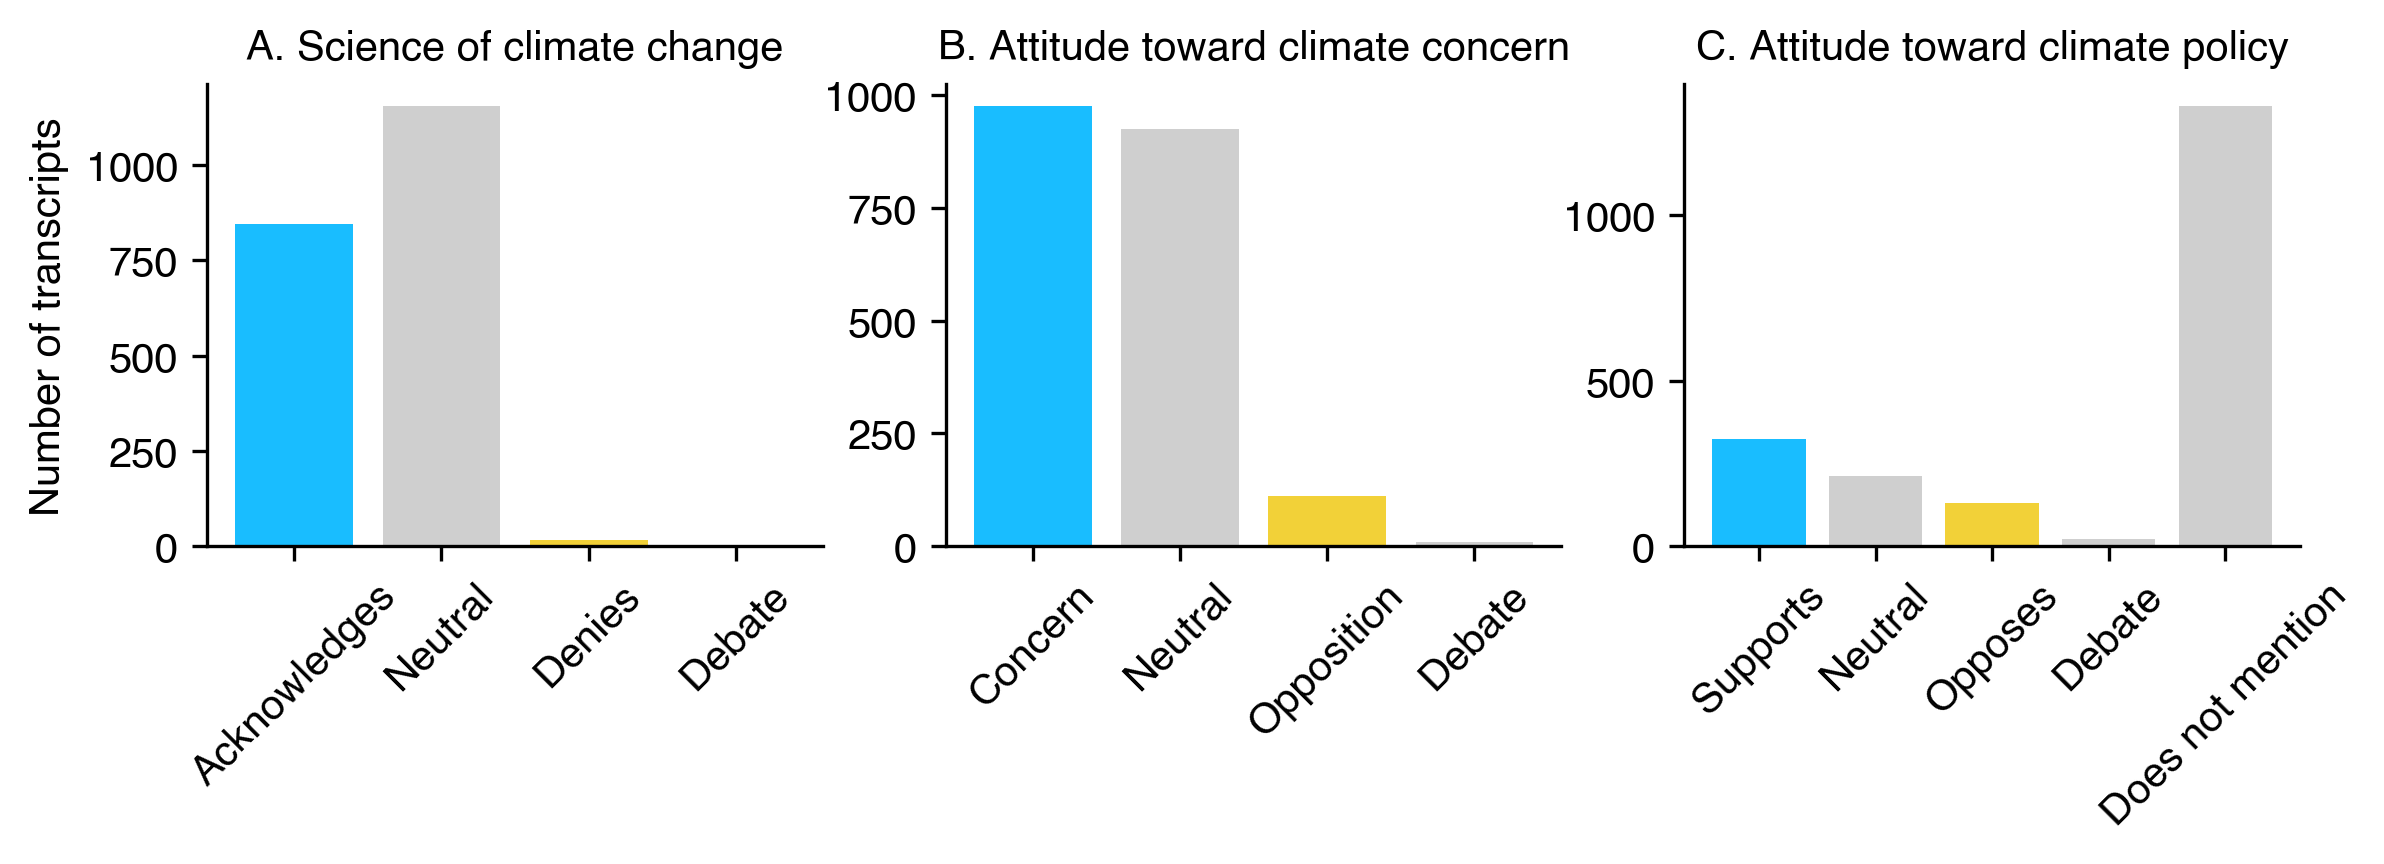

In [72]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2),dpi=300)

# Plot each response list in a subplot
plot_responses_test(axs[0], response_list_Q1, Q1_choices, 'A. Science of climate change')
plot_responses_test(axs[1], response_list_Q2, Q2_choices, 'B. Attitude toward climate concern', labels=short_Q2_choices, yoff=True)
plot_responses_test(axs[2], response_list_Q3, Q3_choices, 'C. Attitude toward climate policy', labels=Q3_choices, yoff=True)

# Adjust layout to increase space between subplots
plt.subplots_adjust(hspace=0.5)

 # Increase hspace to add more vertical space between subplots
plt.savefig("99_figures/media_bar_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Splitting by media outlet

In [73]:
# Step 2: Identify unique media outlets
media_outlets = df['media_outlet'].unique()

# Step 3: Split the DataFrame

Q1_outlet_dfs={}
for outlet in media_outlets:
    # Selecting only the columns corresponding to the current media outlet
    Q1_outlet_df = Q1_df.xs(outlet, level='media_outlet', axis=1)
    Q1_outlet_dfs[outlet] = Q1_outlet_df

Q2_outlet_dfs={}
for outlet in media_outlets:
    # Selecting only the columns corresponding to the current media outlet
    Q2_outlet_df = Q2_df.xs(outlet, level='media_outlet', axis=1)
    Q2_outlet_dfs[outlet] = Q2_outlet_df

Q3_outlet_dfs={}
for outlet in media_outlets:
    # Selecting only the columns corresponding to the current media outlet
    Q3_outlet_df = Q3_df.xs(outlet, level='media_outlet', axis=1)
    Q3_outlet_dfs[outlet] = Q3_outlet_df

In [74]:
def calculate_mode_dfs(outlet_dfs):
    majority_response = {}
    for key, df in outlet_dfs.items():
        # Apply the lambda function to each column of the dataframe
        mode_df = df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Save the mode_df back into the dictionary under the same key
        response_list=mode_df.tolist()
        majority_response[key]=response_list

    return majority_response

In [75]:
def calculate_nonNA_responses(outlet_dfs):
    results = {}

    for key, df in outlet_dfs.items():
        # Get list of lists of non-NaN values from each column
        non_na_values = [col.dropna().tolist() for _, col in df.items()]
        
        # Flatten the list of lists
        flat_list = [item for sublist in non_na_values for item in sublist]
        
        results[key] = flat_list

    return results

In [76]:
Q1_majority_response=calculate_mode_dfs(Q1_outlet_dfs)
Q2_majority_response=calculate_mode_dfs(Q2_outlet_dfs)
Q3_majority_response=calculate_mode_dfs(Q3_outlet_dfs)


In [77]:
Q3_nonNA_response=calculate_nonNA_responses(Q3_outlet_dfs)

In [91]:
Q3_nonNA_response['Fox'].count('Opposes')

252

In [79]:
def plot_response_counts_row(choices, majority_response, suptitle, labels=None, color_bars=False, same_y_axis_limits=True):
    """
    Plot a figure with multiple subplots, each representing response counts for a key in the majority_response.

    Parameters:
    choices (list): A list of possible response choices.
    majority_response (dict): A dictionary where keys are categories and values are lists of responses.
    suptitle (str): The overall title for the figure.
    color_bars (bool): Whether to color the first bar as mygreen and the third bar as myred in each plot.
    myblack (str): Color for text and spines.
    mygreen (str): Color for the first bar if color_bars is True.
    myred (str): Color for the third bar if color_bars is True.
    mygrey (str): Color for the bars.
    same_y_axis_limits (bool): Whether to set the same y-axis limits for all subplots.
    """

    # Number of subplots
    n_subplots = len(majority_response)
    n_cols = 7  # Set the number of columns to 7 for one row of subplots
    n_rows = 1  # Only one row needed for seven subplots in a row

    # Set Helvetica as the default font
    plt.rcParams['font.family'] = 'Helvetica'

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 2))  # Adjust the size as needed

    max_counts = []  # To store maximum counts for y-axis limits

    for i, (key, response_list) in enumerate(majority_response.items()):
        ax = axs[i]
        
        # Count responses and order them
        response_counts = Counter(response_list)
        ordered_counts = [response_counts[choice] for choice in choices]
        
        if labels is None:
            labels = choices
        
        # Determine bar colors
        bar_colors = [mygrey] * len(choices)
        if color_bars:
            bar_colors[0] = mygreen  # First bar color
            bar_colors[2] = myred  # Third bar color
        
        # Plotting
        ax.bar(labels, ordered_counts, color=bar_colors)
        ax.set_title(f"{key}", color=myblack)
        if i == 0:
            ax.set_ylabel('Number of transcripts', color=myblack)
        ax.tick_params(axis='x', rotation=45, colors=myblack)
        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_color(myblack)  # Set bottom spine color
        ax.spines['left'].set_color(myblack)  # Set left spine color
        
        max_counts.append(max(ordered_counts))  # Append maximum count for y-axis limits

    # Set the same y-axis limits for all subplots if required
    if same_y_axis_limits:
        max_count = max(max_counts)
        for ax in axs:
            ax.set_ylim(0, max_count)

    # Set the suptitle for the figure
    fig.suptitle(suptitle, fontsize=16, color=myblack)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rectangle for tight_layout to consider suptitle
    plt.show()

['ABC', 'CBS', 'CNN', 'Fox', 'MSNBC', 'NBC', 'PBS']


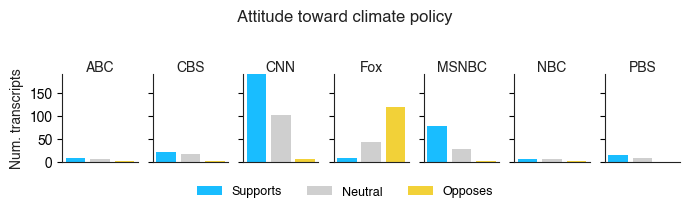

In [80]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def swap_second_and_third_keys(d):
    keys = list(d.keys())
    
    if len(keys) < 3:
        return d  # No need to swap if there are fewer than 3 keys
    
    # Swap the second and third keys
    keys[1], keys[2] = keys[2], keys[1]
    
    # Create a new ordered dictionary with the swapped keys
    new_dict = {key: d[key] for key in keys}
    
    return new_dict

def plot_response_counts_row(choices, majority_response, suptitle=None, labels=None, color_bars=False, same_y_axis_limits=True):
    """
    Plot a figure with multiple subplots in a row, each representing response counts for a key in the majority_response.

    Parameters:
    choices (list): A list of possible response choices.
    majority_response (dict): A dictionary where keys are categories and values are lists of responses.
    suptitle (str): The overall title for the figure.
    color_bars (bool): Whether to color the first bar as mygreen and the third bar as myred in each plot.
    myblack (str): Color for text and spines.
    mygreen (str): Color for the first bar if color_bars is True.
    myred (str): Color for the third bar if color_bars is True.
    mygrey (str): Color for the bars.
    same_y_axis_limits (bool): Whether to set the same y-axis limits for all subplots.
    """

    # Swap the second and third keys
    majority_response = swap_second_and_third_keys(majority_response)

    # Number of subplots
    n_subplots = len(majority_response)
    n_cols = 7  # Set the number of columns to 7 for one row of subplots
    n_rows = 1  # Only one row needed for seven subplots in a row

    # Set Helvetica as the default font
    plt.rcParams['font.family'] = 'Helvetica'

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7, 2))  # Width is 7 inches, height adjusted accordingly

    max_counts = []  # To store maximum counts for y-axis limits
    print(sorted(majority_response))
    for i, (key, response_list) in enumerate(sorted(majority_response.items())):
        ax = axs[i]
        
        # Count responses and order them
        response_counts = Counter(response_list)
        ordered_counts = [response_counts[choice] for choice in choices]
        
        if labels is None:
            labels = choices
        
        # Determine bar colors
        bar_colors = [mygrey] * len(choices)
        if color_bars:
            bar_colors[0] = mygreen  # First bar color
            bar_colors[2] = myred  # Third bar color
        
        # Plotting
        bars = ax.bar(labels, ordered_counts, color=bar_colors)
        ax.set_title(f"{key}", color=myblack, pad=2)  # Reduce the padding for subplot titles
        if i == 0:
            ax.set_ylabel('Num. transcripts', color=myblack)
        else:
            ax.set_yticklabels([])  # Remove y-axis labels for all subplots except the first one
        
        # Set more x-ticks
        #ax.set_xticks(range(len(labels)))
        #ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8, color=myblack)
        ax.set_xticks([])

        ax.spines['top'].set_visible(False)  # Remove top spine
        ax.spines['right'].set_visible(False)  # Remove right spine
        ax.spines['bottom'].set_color(myblack)  # Set bottom spine color
        ax.spines['left'].set_color(myblack)  # Set left spine color
        
        max_counts.append(max(ordered_counts))  # Append maximum count for y-axis limits

    # Set the same y-axis limits for all subplots if required
    if same_y_axis_limits:
        max_count = max(max_counts)
        for ax in axs:
            ax.set_ylim(0, max_count)
            y_ticks = [0,50,100,150]#np.linspace(0, max_count, 4)
            ax.set_yticks(y_ticks)
            if ax != axs[0]:
                ax.set_yticklabels([])  # Remove y-axis labels for all subplots except the first one

    # Set the suptitle for the figure
    if suptitle!=None:
        fig.suptitle(suptitle, fontsize=12, color=myblack)

    # Add legend below subplots
    legend_labels = labels if labels else choices
    fig.legend(bars, legend_labels, loc='lower center', ncol=len(legend_labels), frameon=False)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust the rectangle for tight_layout to consider suptitle and legend
    plt.subplots_adjust(wspace=0.2, hspace=-1)  # Adjust the space between subplots, reduce the space between suptitle and subplot titles

    # plt.show()


choices = ['Supports', 'Neutral', 'Opposes']
plot_response_counts_row(short_Q3_choices, Q3_majority_response, suptitle='Attitude toward climate policy', labels=choices, color_bars=True, same_y_axis_limits=True)
plt.savefig('99_figures/media_by_outlet.pdf',dpi=dpival)


In [81]:
def plot_response_counts_grid(choices, majority_response, ax_grid, suptitle=None, labels=None, divide_by_two=False):
    # Set Helvetica as the default font
    plt.rcParams['font.family'] = 'Helvetica'
    
    # Track the maximum count for consistent y-axis limits
    max_counts = []

    for i, (key, response_list) in enumerate(sorted(majority_response.items())):
        ax = ax_grid[i]

        # Count responses and order them
        response_counts = Counter(response_list)
        ordered_counts = [response_counts[choice] for choice in choices]

        # Optionally divide all counts by 2 to normalize by number of annotators when using nonNA counts
        if divide_by_two:
            ordered_counts = [count / 2 for count in ordered_counts]
            print(key, ordered_counts)

        if labels is None:
            labels = choices

        # Plotting
        ax.bar(labels, ordered_counts, color=[mygreen, mygrey, myred])
        ax.set_title(f"{key}", pad=2)

        if i % 8 == 0:
            ax.set_ylabel('Number of transcripts', fontsize=SMALL_SIZE)
            ax.yaxis.set_label_coords(-0.7, -0.1)

        ax.set_xticks([])
        sns.despine(ax=ax)

        max_counts.append(max(ordered_counts))

    # Set the same y-axis limits for all subplots
    max_count = max(max_counts)
    for ax in ax_grid:
        ax.set_ylim(0, max_count)

    # Set the suptitle if provided
    if suptitle:
        plt.suptitle(suptitle, fontsize=12)


In [82]:
def plot_responses_plus_weighted(response_list, choices, title, color_bars=True, labels=None, xlabel_fontsize=12, ylabel_fontsize=12,ax=None,Q3_weighted_counts_list=None, total_weighted_count=None):
    """
    Plot a bar chart of response counts.

    Parameters:
    - response_list: List of responses to count.
    - choices: List of possible choices to ensure the correct order in the plot.
    - title: Title of the plot.
    - color_bars: Boolean indicating whether to color the bars differently.
    - labels: Optional custom labels for the bars.
    - xlabel_fontsize: Font size for the x-axis labels.
    - ylabel_fontsize: Font size for the y-axis labels.
    """
    # Count the occurrences of each response
    response_counts = Counter(response_list)
    # Reorder the response counts according to the order in choices
    ordered_counts = [response_counts[choice] for choice in choices]
    ordered_counts = [response_counts[choice] for choice in choices]
    Q3_choices=["Supports","Neutral","Opposes","Debate","Does not mention"]
    total_ordered_counts = [response_counts[choice] for choice in Q3_choices]

    total_count = sum(total_ordered_counts)#sum(ordered_counts)  # Calculate total to convert counts to density
    density_counts = [count / total_count for count in ordered_counts]  # Normalize to make it a density


    if labels is None:
        labels = choices
        
    # Determine bar colors
    bar_colors = [mygrey] * len(choices)
    if color_bars:
        bar_colors[0] = mygreen  # First bar color
        bar_colors[2] = myred  # Third bar color



        # Plotting with the order of choices
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
    ax.bar(labels, density_counts, color=bar_colors)

        
    # Overlay weighted counts with dashed outlines if provided
    if list is not None:
        # Normalize Q3_weighted_counts_list to density
        total_weighted_count = total_weighted_count
        weighted_density = [count / total_weighted_count for count in Q3_weighted_counts_list[0:3]]  # Only take the first three counts for Supports, Neutral, Opposes
                # Plot overlay with dashed edges
        ax.bar(labels, weighted_density, color='none', edgecolor=myblack, linestyle='--', linewidth=1.5, 
               label="Weighted Counts")
        

    # Customize the plot
    ax.set_title(title)
    ax.set_ylabel('Fraction of transcripts', fontsize=SMALL_SIZE)
    # ax.set_xticks(range(len(labels)))
    ax.set_xticklabels([]) #, rotation=45, fontsize=xlabel_fontsize)
    sns.despine(ax=ax)



    # Create legend handles
    legend_labels = ["Supports", "Neutral", "Opposes", "Weighted"]
    legend_handles = [
        plt.Line2D([0], [0], color=mygreen, marker='s', linestyle='', linewidth=1.5, markersize=9),  # Supports
        plt.Line2D([0], [0], color=mygrey, marker='s', linestyle='', linewidth=1.5, markersize=9),   # Neutral
        plt.Line2D([0], [0], color=myred, marker='s', linestyle='', linewidth=1.5, markersize=9),    # Opposes
        plt.Line2D([0], [0], color=myblack, linestyle='--', linewidth=1.5)                            # Weighted (dashed line only)
    ]
    
    # Add the legend to the plot
    ax.legend(legend_handles, legend_labels, loc='upper right', frameon=False)
    
    # Add the legend to the plot
    ax.legend(legend_handles, legend_labels, loc='upper right', frameon=False)

    # Display the plot
    plt.show()

In [83]:
# Load dictionary from a JSON file
with open("output/Q3_weighted_counts.json", "r") as json_file:
    Q3_weighted_counts = json.load(json_file)

In [84]:
Q3_weighted_counts_list=[]
for i in range(3):
    summed_views = Q3_weighted_counts['cable_lib'][i]+ Q3_weighted_counts['tv_news'][i]+Q3_weighted_counts['Fox'][i]
    Q3_weighted_counts_list.append(summed_views)


In [85]:
Q3_weighted_counts_list_total=[]
for i in range(5):
    summed_views = Q3_weighted_counts['cable_lib'][i]+ Q3_weighted_counts['tv_news'][i]+Q3_weighted_counts['Fox'][i]
    Q3_weighted_counts_list_total.append(summed_views)

total_weighted_count = sum(Q3_weighted_counts_list_total)

In [86]:
def plot_response_distribution_from_df(response_df, choices, title=None, color_bars=True, ax=None, Q3_weighted_counts_list=None, total_weighted_count=None):
    """
    Plot a bar chart of response proportions, with optional dashed outlines
    to show weighted proportions.

    Parameters:
    - response_df: DataFrame with columns 'Response', 'Value', 'Proportion'.
    - choices: Ordered list of response categories to plot.
    - title: Plot title.
    - color_bars: Whether to color specific categories (Supports/Neutral/Opposes).
    - ax: Optional matplotlib axis to plot on.
    - Q3_weighted_counts_list: Optional list of weighted counts to overlay.
    - total_weighted_count: Total used to normalize the weighted counts.
    """
    # Match order of responses
    ordered_df = response_df.set_index("Response").reindex(choices).reset_index()
    proportions = ordered_df["Proportion"].fillna(0).tolist()
    labels = ordered_df["Response"].tolist()

    # Bar colors
    bar_colors = [mygrey] * len(choices)
    if color_bars:
        if "Supports" in choices:
            bar_colors[choices.index("Supports")] = mygreen
        if "Opposes" in choices:
            bar_colors[choices.index("Opposes")] = myred

    # Initialize plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3), dpi=300)

    ax.bar(labels, proportions, color=bar_colors)

    # Overlay weighted counts with dashed outlines if provided
    if Q3_weighted_counts_list is not None and total_weighted_count is not None:
        weighted_density = [count / total_weighted_count for count in Q3_weighted_counts_list]
        ax.bar(
            labels,
            weighted_density,
            color='none',
            edgecolor=myblack,
            linestyle='--',
            linewidth=1,
            label="Weighted Counts"
        )

     # Style
    ax.set_title(title)
    ax.set_ylabel('% of transcripts', fontsize=SMALL_SIZE)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    ax.set_xticks([])        # Remove x-axis ticks
    ax.set_xticklabels([])  # Hide x-axis labels
    sns.despine(ax=ax)

    # Create legend handles
    legend_labels = ["Supports", "Neutral", "Opposes", "Weighted"]
    legend_handles = [
        plt.Line2D([0], [0], color=mygreen, marker='s', linestyle='', linewidth=1.5, markersize=10),  # Supports
        plt.Line2D([0], [0], color=mygrey, marker='s', linestyle='', linewidth=1.5, markersize=10),   # Neutral
        plt.Line2D([0], [0], color=myred, marker='s', linestyle='', linewidth=1.5, markersize=10),    # Opposes
        plt.Line2D([0], [0], color=myblack, linestyle='--', linewidth=1.5)                            # Weighted
    ]

    ax.legend(legend_handles, legend_labels, loc='upper right',   fontsize=8,
    markerscale=0.8, frameon=False)

    plt.show()


In [87]:

# def plot_combined_layout(choices, majority_response, response_list_Q3, short_Q3_choices, labels=None,Q3_weighted_counts_list=None,total_weighted_count=None):
#     # Create a gridspec layout with 5 columns (4 for the 2x4 layout and 1 for the single plot)
#     fig = plt.figure(figsize=(7, 2.5), dpi=300)
#     gs = fig.add_gridspec(2, 6, width_ratios=[3, 0.5,1, 1, 1, 1], height_ratios=[1, 1], wspace=0.4, hspace=0.4)

#     # Left side: 2x4 grid plot (7 subplots in an 8-grid structure, leaving one empty at the bottom-right)
#     ax_grid = [fig.add_subplot(gs[i // 4, i % 4 +2]) for i in range(7)]
#     plot_response_counts_grid(choices, majority_response, ax_grid=ax_grid, suptitle="", labels=labels)

#     # fig.suptitle("Attitude toward climate policy", fontsize=12, y=1.05) 
#     # Place the title with fig.text at a custom position
#     fig.text(0.5, 1.05, "Attitude toward climate policy", ha='center', fontsize=12)
#     # Right side: Single bar plot spanning both rows in the fifth column
#     ax_single = fig.add_subplot(gs[:, 0])  # Use both rows of the fifth column only
#     plot_responses_plus_weighted(response_list_Q3, short_Q3_choices, ax=ax_single, title='Attitude toward climate policy', labels=short_Q3_choices,Q3_weighted_counts_list=Q3_weighted_counts_list)
    
#     fig.tight_layout() 
#     # Display the combined plot
#     fig.savefig('99_figures/media_by_outlet_plus_totals.pdf',dpi=dpival)
#     fig.subplots_adjust(top=0.7)
    
#     plt.show()
#     return fig


def plot_combined_layout(
    choices,
    Q3_nonNA_response,
    response_list_Q3,
    short_Q3_choices,
    labels=None,
    Q3_weighted_counts_list=None,
    total_weighted_count=None
):
    # Create a gridspec layout
    fig = plt.figure(figsize=(7, 2.5), dpi=300)
    gs = fig.add_gridspec(2, 6, width_ratios=[3, 0.5, 1, 1, 1, 1], height_ratios=[1, 1], wspace=0.4, hspace=0.4)

    # Left side: 2x4 grid plot
    ax_grid = [fig.add_subplot(gs[i // 4, i % 4 + 2]) for i in range(7)]
    plot_response_counts_grid(choices, Q3_nonNA_response, ax_grid=ax_grid, suptitle="", labels=labels, divide_by_two=True)

    # Title
    # fig.text(0.5, 1.05, "Attitude toward climate policy", ha='center', fontsize=12)

    # Right side: single vertical bar plot
    ax_single = fig.add_subplot(gs[:, 0])
    plot_response_distribution_from_df(
        response_df=Q3_response_counts,
        choices=short_Q3_choices,
        ax=ax_single,
        title='Attitude toward climate policy',
        color_bars=True,
        Q3_weighted_counts_list=Q3_weighted_counts_list,
        total_weighted_count=total_weighted_count  
    )

    # Create custom legend handles (same as before)
    legend_labels = ["Supports", "Neutral", "Opposes", "Weighted"]
    legend_handles = [
        plt.Line2D([0], [0], color=mygreen, marker='s', linestyle='', linewidth=1.5, markersize=8),
        plt.Line2D([0], [0], color=mygrey, marker='s', linestyle='', linewidth=1.5, markersize=8),
        plt.Line2D([0], [0], color=myred, marker='s', linestyle='', linewidth=1.5, markersize=8),
        plt.Line2D([0], [0], color=myblack, linestyle='--', linewidth=1.5)
    ]


    fig.tight_layout()
    # fig.subplots_adjust(top=0.7)
    fig.savefig('99_figures/media_by_outlet_plus_totals.pdf', dpi=dpival)

    plt.show()
    return fig


ABC [9.5, 6.0, 2.5]
CBS [21.5, 19.5, 1.0]
CNN [195.0, 108.0, 6.5]
Fox [8.5, 42.0, 126.0]
MSNBC [78.5, 29.5, 1.0]
NBC [5.0, 5.0, 1.5]
PBS [15.0, 10.0, 0.0]


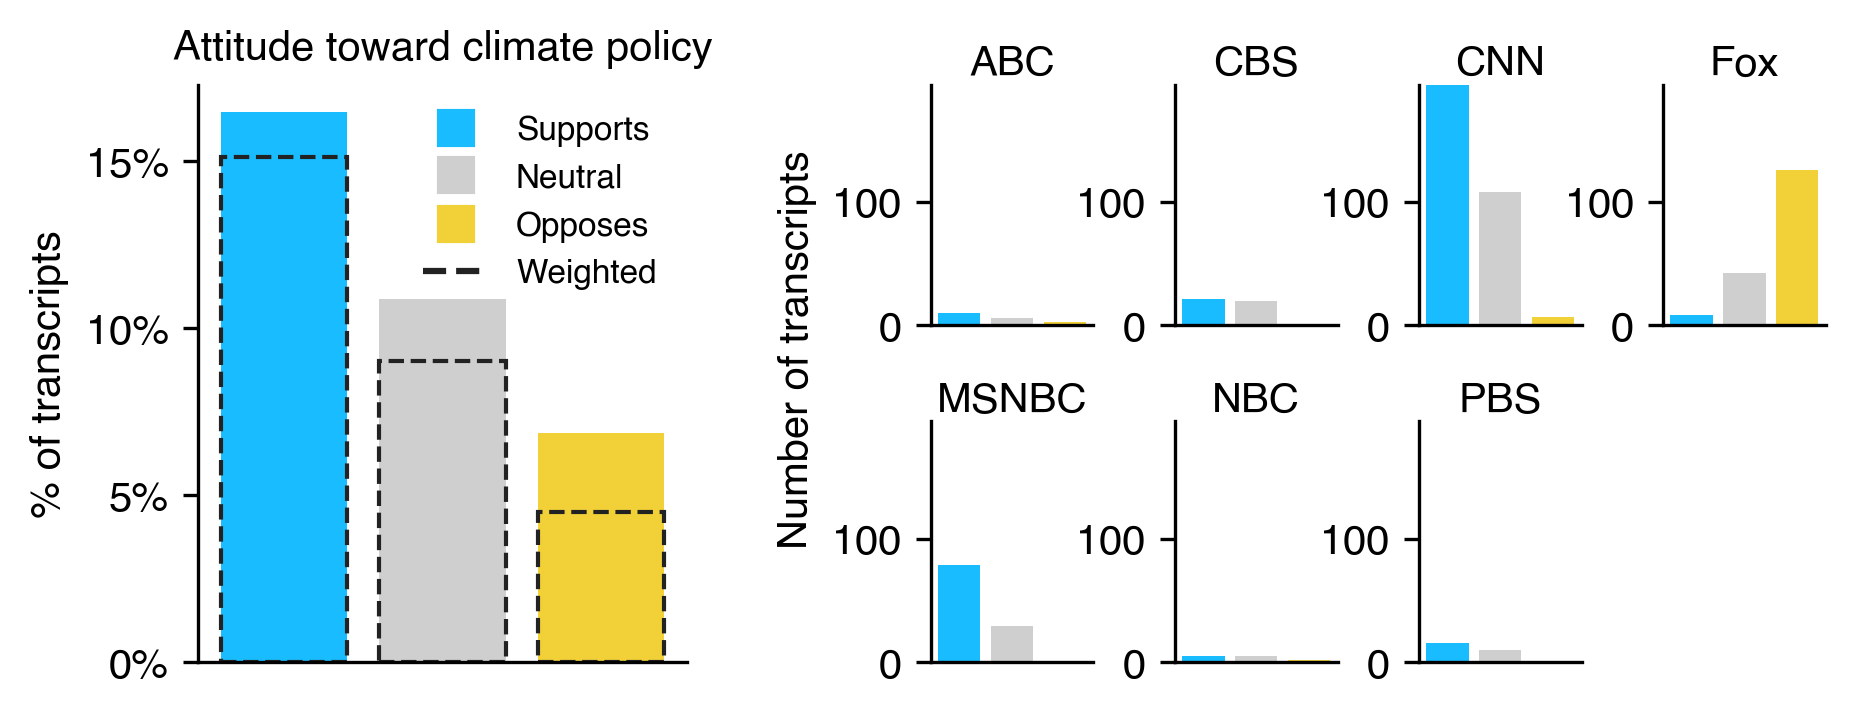

/var/folders/v0/mrdbnbz979z112bjxxhzr3zh0000gn/T/ipykernel_36464/3525179871.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [88]:
fig= plot_combined_layout(short_Q3_choices, Q3_nonNA_response, response_list_Q3, short_Q3_choices,Q3_weighted_counts_list=Q3_weighted_counts_list, total_weighted_count=total_weighted_count)


ABC [9.5, 6.0, 2.5, 0.0, 72.0]
CBS [21.5, 19.5, 1.0, 0.0, 137.0]
CNN [195.0, 108.0, 6.5, 2.5, 599.5]
Fox [8.5, 42.0, 126.0, 9.0, 209.0]
MSNBC [78.5, 29.5, 1.0, 3.5, 201.5]
NBC [5.0, 5.0, 1.5, 0.0, 47.0]
PBS [15.0, 10.0, 0.0, 4.0, 40.0]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (3,).

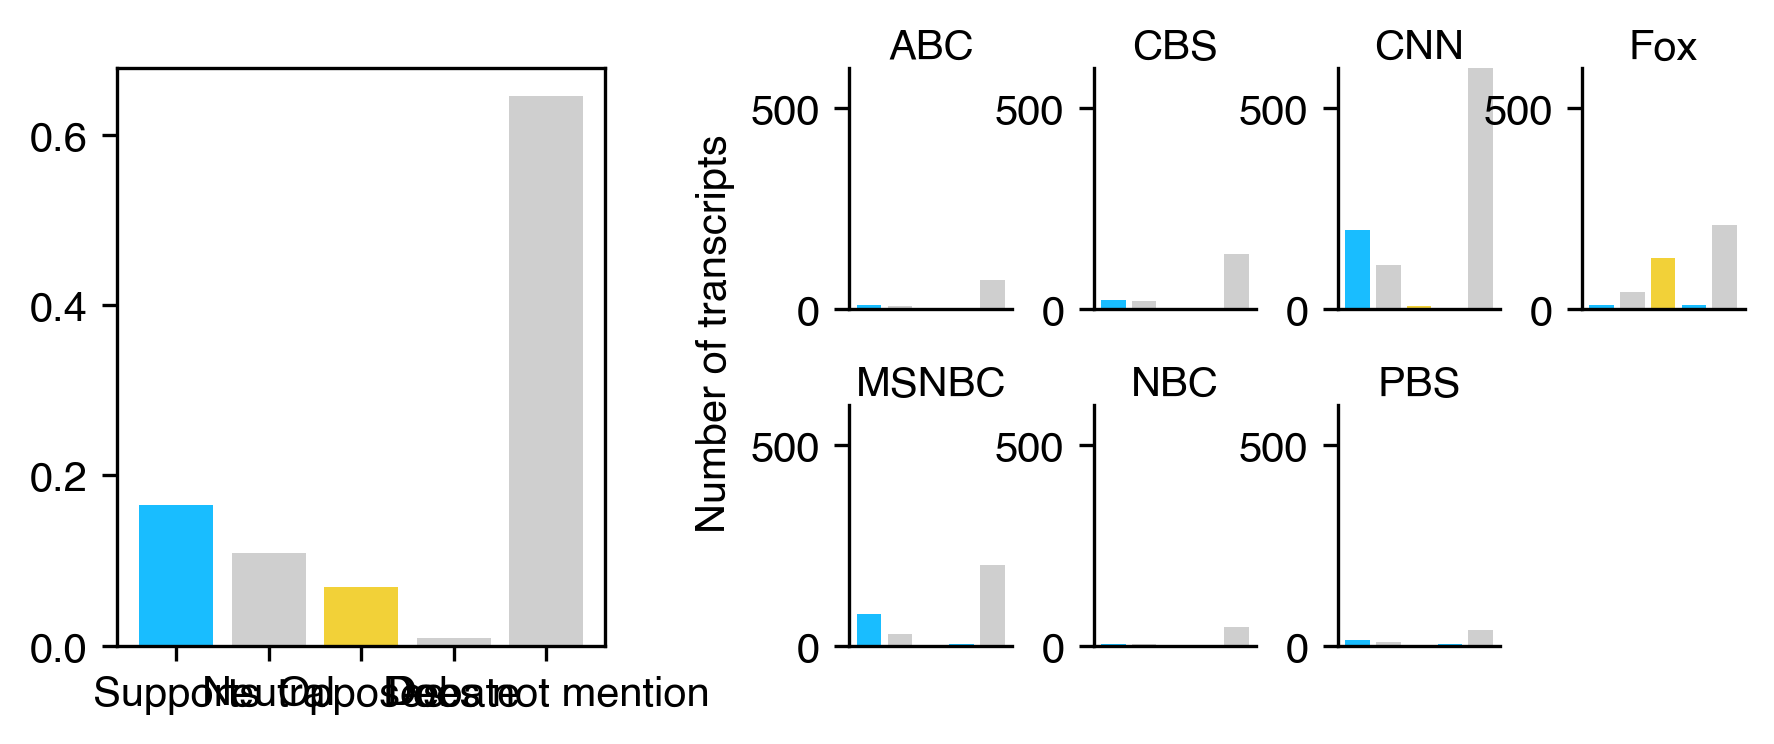

In [89]:
fig= plot_combined_layout(Q3_choices, Q3_nonNA_response, response_list_Q3, Q3_choices,Q3_weighted_counts_list=Q3_weighted_counts_list, total_weighted_count=total_weighted_count)
